# NAT Meter stats

In [1]:
import requests
from datetime import datetime
%matplotlib inline

In [2]:
CHARTS_ASPECT = (15, 3)
XAXIS_FORMAT = '%m-%Y'

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot(x, y, title="", xlabel="Date (mm-yyyy)", ylabel=""):
    
    plt.figure(figsize=CHARTS_ASPECT)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(XAXIS_FORMAT))
    xticks = list(set([_.replace(day=1, hour=0, minute=0, second=0, microsecond=0) for _ in x]))  # truncated dates --> (y,m,d)
    
    plt.plot_date(
        x, y,
        color=plt.get_cmap('Reds')(200), # TODO linestyle='solid'
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(linestyle='dotted')
    plt.xticks(xticks, rotation=30)
    
    plt.show()
    
BASE_URL = "https://natmeter.labs.lacnic.net/reports"

def fetch(url):
    _dict = {}
    
    response = requests.get(BASE_URL + url)
    entries = response.text.split("\n")
    for e in entries:
        if "," in e:
            k,v = e.split(",")
            _dict[datetime.strptime(k, '%Y-%m-%d')] = int(v)
    return _dict

## Dualstack

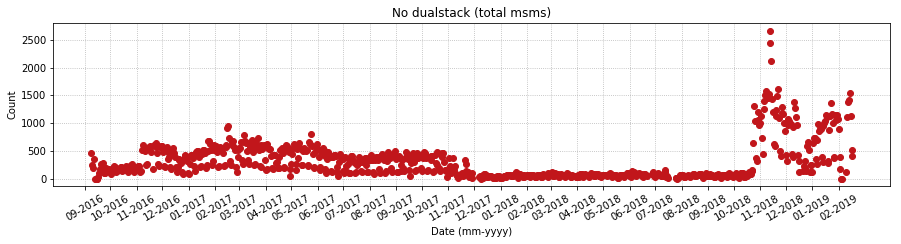

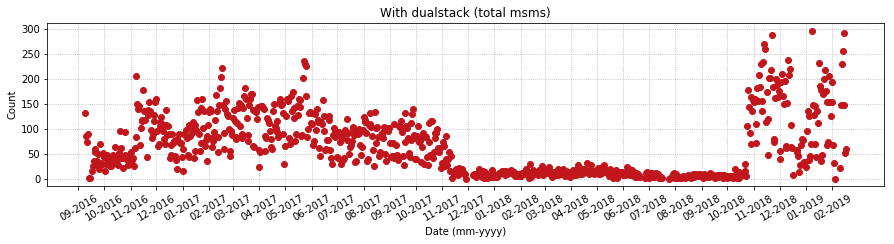

In [4]:
urls = ["/dualstack_false", "/dualstack_true"]
titles = ["No dualstack (total msms)", "With dualstack (total msms)"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## Dualstack ratio (true / total)

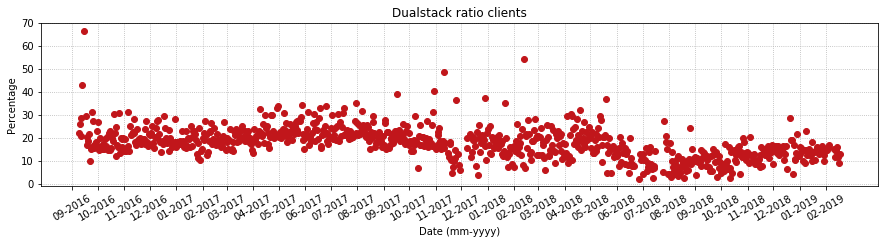

In [5]:
chart = {}

for k,v in answers["/dualstack_true"].items():
    ratio = 100.0*v / (answers["/dualstack_false"][k] + v)
    chart[k] = ratio

plot(
    chart.keys(), chart.values(), title="Dualstack ratio clients", ylabel="Percentage"
)

## NAT (any)

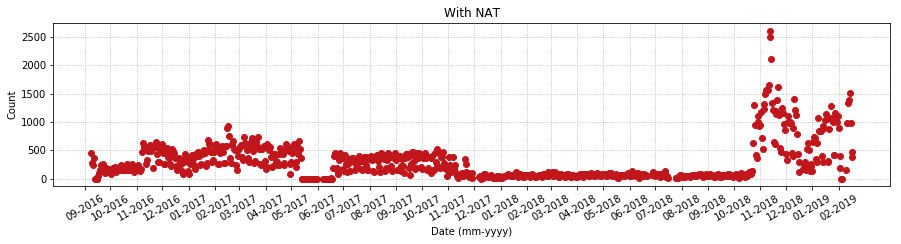

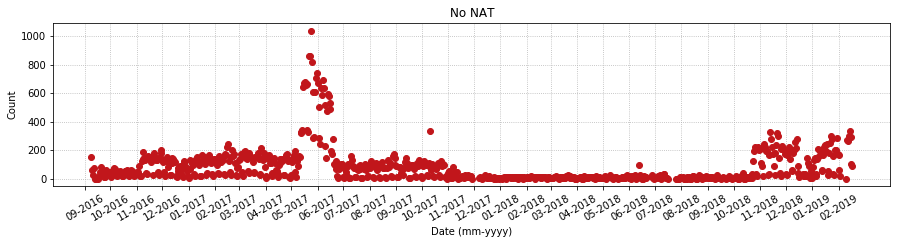

In [6]:
# plotting
urls = ["/nat_free_0_false", "/nat_free_0_true"]
titles = ["With NAT", "No NAT"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT (any) ratio

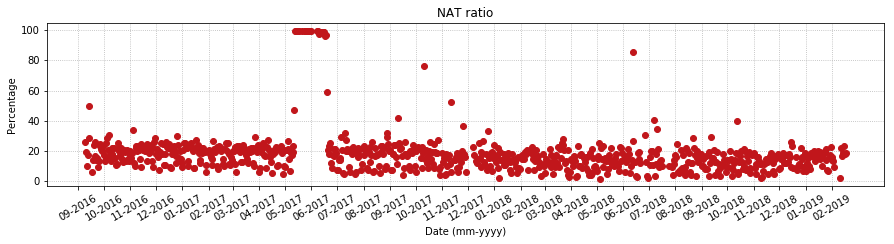

In [7]:
chart = {}

for k,v in answers["/nat_free_0_true"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_0_false"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT ratio", ylabel="Percentage"
)

## NAT 66

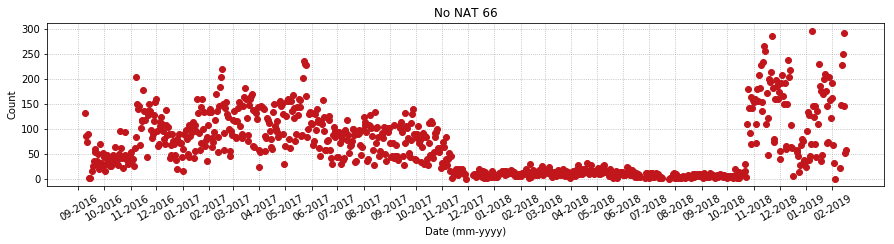

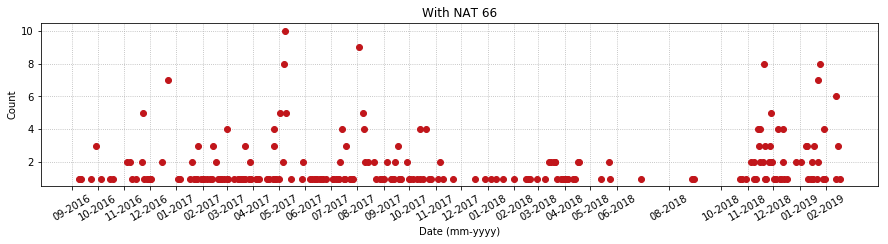

In [8]:
# plotting
urls = ["/nat_free_6_true", "/nat_free_6_false"]
titles = ["No NAT 66", "With NAT 66"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT 66 ratio

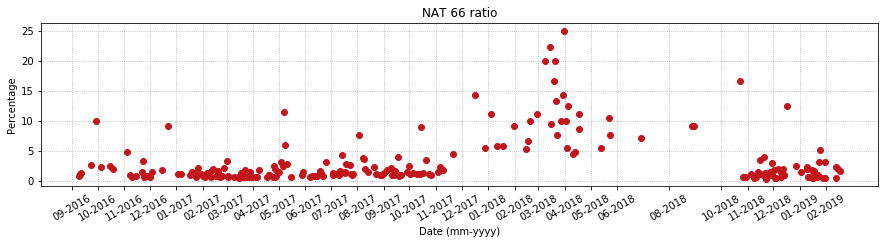

In [9]:
chart = {}

for k,v in answers["/nat_free_6_false"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_6_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT 66 ratio", ylabel="Percentage"
)

## NAT 44

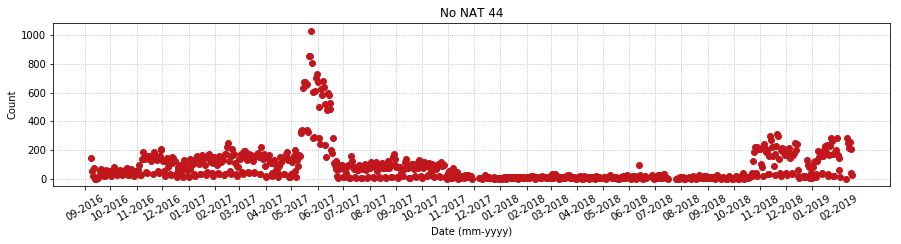

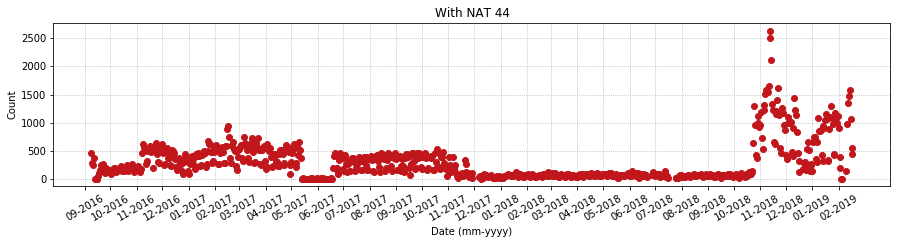

In [10]:
# plotting
urls = ["/nat_free_4_true", "/nat_free_4_false"]
titles = ["No NAT 44", "With NAT 44"]

answers = {}
for i, url in enumerate(urls):
    _dict = fetch(url)
    answers[url] = _dict
    
    plot(
        _dict.keys(), _dict.values(), title=titles[i], ylabel="Count"
    )

## NAT 44 ratio

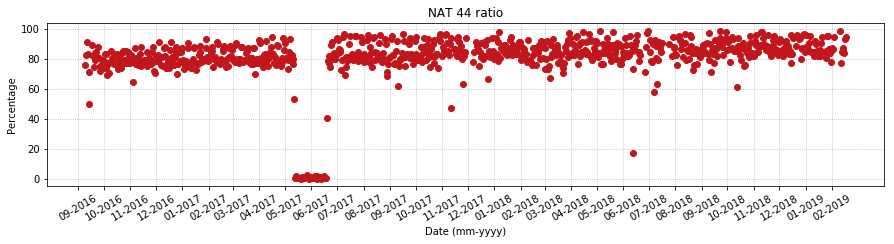

In [11]:
chart = {}

for k,v in answers["/nat_free_4_false"].items():
    try:
        ratio = 100.0*v / (answers["/nat_free_4_true"][k] + v)
    except KeyError:
        continue
        
    chart[k] = ratio
    
plot(
    chart.keys(), chart.values(), title="NAT 44 ratio", ylabel="Percentage"
)

In [12]:
url = "https://natmeter.labs.lacnic.net/static/results.csv"

In [13]:
response = requests.get(url)

In [14]:
import json
from collections import Counter, defaultdict
from datetime import timedelta

dates = []
entries = response.text.split("\n")
date2pfxs = defaultdict(list)

for e in entries:
    if '#' in e or '\n' == e or '\r' == e:
        continue
    
    # headers
    if '[' not in e:
        continue
    
    e = e.replace('\'', '')
    
    private, public, date = e.split('\t')
    private = private.replace('[', '').replace(']', '').decode('utf-8').split(', ')
    public = public.replace('[', '').replace(']', '').decode('utf-8').split(', ')
    date = date.replace('\r', '')
    
    date = datetime.strptime(date, '%Y-%m-%d')
    
    dates.append(date)
    date2pfxs[date] += public
    

In [15]:
start = min(date2pfxs.keys())
end = max(date2pfxs.keys())

current = start
delta = timedelta(days=90)

timeseries = defaultdict(datetime)
while current <= end:
    w_pfxs = [p for d,p in date2pfxs.items() if current-delta < d <= current]
    w_pfxs = [item for sublist in w_pfxs for item in sublist]

    w_unique_pfxs = len(set(Counter(w_pfxs)))
    timeseries[current] = w_unique_pfxs
    
    current += timedelta(days=1)

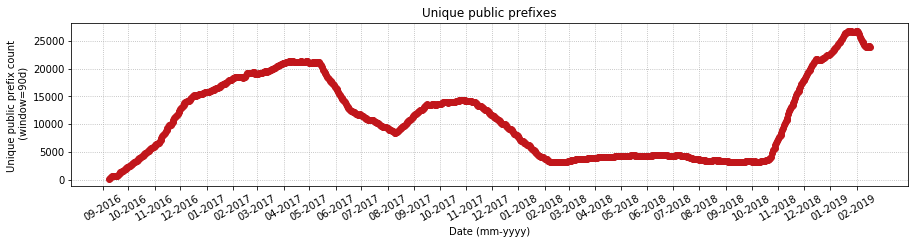

In [16]:
plot(
    timeseries.keys(),
    timeseries.values(),
    title="Unique public prefixes",
    ylabel="Unique public prefix count \n (window=90d)"
)